In [1]:
# ==========================================
# 1. DATENVORBEREITUNG (für alle Schadstoffe)
# ==========================================
# (Angenommen, dein DataFrame heißt df und wurde bereits eingelesen, 
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Mapping der Spaltennamen anwenden
rename_dict = {
    "Stationscode": "code",
    "Stationsname": "name",
    "Stationsumgebung": "area",
    "Art der Station": "type",
    "Timestamp": "timestamp",
    "Einheit": "unit",
    "Feinstaub (PM₁₀)": "pm10",
    "Feinstaub (PM₂,₅)": "pm25",
    "Kohlenmonoxid (CO)": "co",
    "Ozon (O₃)": "o3",
    "Schwefeldioxid (SO₂)": "so2",
    "Stickstoffdioxid (NO₂)": "no2"
}

data_path = Path.cwd() / "Luftqualitaet_Zusammenfassung.csv"
df = pd.read_csv(data_path, encoding="UTF-8", sep=";")

# Benenne die Spalten im DataFrame um
df.rename(columns=rename_dict, inplace=True)

# Stelle sicher, dass timestamp ein Datetime-Objekt ist
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df["time"] = df["timestamp"].dt.time
df["date"] = df["timestamp"].dt.date

# Definiere deine Schadstoff-Spalten (jetzt inklusive 'co')
pollutant_cols = ["pm10", "pm25", "co", "o3", "so2", "no2"]

df = df.drop(columns=["co"])

# to numeric, coerce errors to NaN
pollutant_cols = ["pm10", "pm25", "o3", "so2", "no2"]
for col in pollutant_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")


# Wir berechnen den Tagesmittelwert, gruppieren diesmal aber nach DATUM UND STATION
# df["timestamp"].dt.date gibt uns nur das Datum ohne Uhrzeit
daily_station_data = df.groupby([df["timestamp"].dt.date, "name"])[pollutant_cols].mean().reset_index()

# Spalte wieder in sauberes Datetime umwandeln und umbenennen
daily_station_data.rename(columns={"timestamp": "Datum"}, inplace=True)
daily_station_data["Datum"] = pd.to_datetime(daily_station_data["Datum"])


/var/folders/1y/b928j3z917s1tz2f3wl_3m5r0000gn/T/ipykernel_2728/2816802975.py:29: DtypeWarning: Columns (0: Feinstaub (PM₂,₅), 1: Kohlenmonoxid (CO), 2: Ozon (O₃), 3: Schwefeldioxid (SO₂)) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, encoding="UTF-8", sep=";")


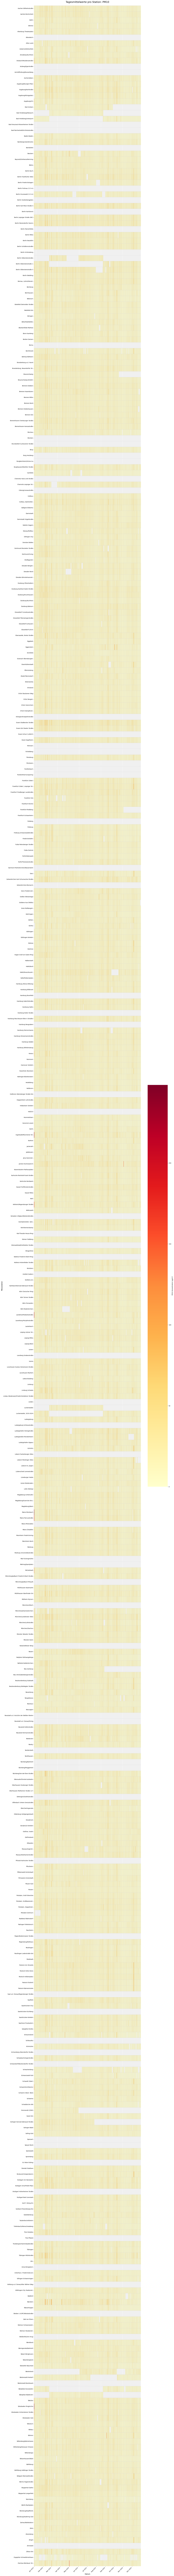

KeyboardInterrupt: 

In [2]:
# ==========================================
# 2. SCHLEIFE FÜR DIE GRAFIKEN (Station vs. Datum)
# ==========================================
for pollutant in pollutant_cols:
    
    # Sicherheitscheck: Gibt es überhaupt Daten?
    if daily_station_data[pollutant].isna().all():
        print(f"⚠️ Überspringe {pollutant.upper()}: Keine gültigen Daten vorhanden.")
        continue
        
    # Erstelle die Pivot-Tabelle: Y-Achse = Station (name), X-Achse = Datum
    heatmap_data = daily_station_data.pivot(index="name", columns="Datum", values=pollutant)
    
    # Erstelle eine breite Figur (breit wegen der 365 Tage)
    # Die Höhe dynamisch an die Anzahl der Stationen anpassen (ca. 0.5 Zoll pro Station)
    anzahl_stationen = len(heatmap_data.index)
    plt.figure(figsize=(18, max(4, anzahl_stationen * 0.6)))

    # Zeichne die Heatmap
    ax = sns.heatmap(
        heatmap_data, 
        cmap="YlOrRd",         
        cbar_kws={"label": f"{pollutant.upper()} Konzentration (µg/m³)", "shrink": 0.8},
        linewidths=0.5,        # Sehr dünne Linien, da wir viele Spalten (Tage) haben
        linecolor="lightgrey",
        annot=False            # Zahlen würden bei 365 Tagen zu klein werden
    )

    # Titel und Achsenbeschriftungen
    plt.title(f"Tagesmittelwerte pro Station: {pollutant.upper()}", fontsize=18, pad=20)
    plt.xlabel("Datum", fontsize=12)
    plt.ylabel("Messstation", fontsize=12) 
    
    # --- X-Achse lesbar machen ---
    # Da Seaborn bei Heatmaps kategoriale Achsen verwendet, müssen wir die Labels manuell filtern,
    # damit nicht 365 Daten übereinander gedruckt werden.
    
    # Hole alle Datums-Strings aus den Spalten
    dates = heatmap_data.columns
    
    # Wir wollen nur Beschriftungen für den 1. jedes Monats anzeigen
    tick_positions = []
    tick_labels = []
    
    for i, date in enumerate(dates):
        if date.day == 1:  # Ist es der Monatserste?
            tick_positions.append(i + 0.5) # +0.5 setzt den Tick in die Mitte des Kästchens
            tick_labels.append(date.strftime("%b %Y")) # Z.B. "Jan 2023"
            
    # Setze die angepassten Ticks und Labels
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45, ha="right", fontsize=10)
    
    # Y-Achse (Stationen) horizontal und gut lesbar halten
    plt.yticks(rotation=0, fontsize=10)

    # Layout optimieren, damit nichts abgeschnitten wird
    plt.tight_layout()

    # Grafik anzeigen
    plt.show()